### Price Range Prediction for electronic products

In [290]:
!pip install spacy
# !pip install webdriver_manager
# !pip install pickle

DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/python_docx-1.1.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/Pattern-3.6.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [291]:
from spacy.cli import download

download("en_core_web_sm")

DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/python_docx-1.1.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/Pattern-3.6.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [292]:
import glob
import re
import string
from typing import List
from typing import Union, Dict
from urllib.parse import unquote, quote_plus

from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import ngrams
import numpy as np
import spacy
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [293]:
import time

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

In [294]:
electronic_household_items = [
    "television", "iron", "vacuum cleaner", "blender", "microwave", "toaster", "coffee maker",
    "dishwasher", "refrigerator", "oven", "washer", "dryer", "air conditioner", "heater", "fan",
    "hair dryer", "electric kettle", "rice cooker", "slow cooker", "pressure cooker", "food processor",
    "mixer", "juicer", "grill", "waffle maker", "sandwich maker", "popcorn maker", "ice cream maker",
    "electric griddle", "hot plate", "water purifier", "humidifier", "dehumidifier", "air purifier",
    "ceiling fan", "space heater", "robot vacuum", "cordless drill", "security camera", "smart doorbell",
    "smart lock", "thermostat", "smart light switch", "smart plug", "smart speaker", "sound bar",
    "home theater system", "streaming device", "gaming console", "router", "smart TV", "wireless charger",
    "Bluetooth speaker", "tablet", "e-reader", "smartphone", "smartwatch", "fitness tracker", "laptop",
    "desktop computer", "monitor", "keyboard", "mouse", "external hard drive", "USB flash drive",
    "headphones", "earbuds", "webcam", "digital camera", "camcorder", "drone", "smart light bulb",
    "electric toothbrush", "electric shaver", "hair straightener", "hair curler", "foot massager",
    "electric blanket", "electric skillet", "bread maker", "sous vide cooker", "food dehydrator",
    "electric wine opener", "electric can opener", "electric knife", "electric pressure washer",
    "smart refrigerator", "smart oven", "smart microwave", "robot lawn mower", "video doorbell",
    "smart garage door opener", "smart blinds", "smart irrigation system", "smart smoke detector",
    "smart carbon monoxide detector", "smart thermostat", "smart security system", "home automation hub",
    "smart scale", "robot mop", "smart ceiling fan", "smart alarm clock"
]

In [295]:
class Product:
    def __init__(self, product_id, name, category, price, description, brand, rating, image_url):
        self.product_id = product_id
        self.name = name
        self.price = price
        self.category = category
        self.description = description
        self.brand = brand
        self.rating = rating
        self.image_url = image_url
        self.reviews = []

    def add_review(self, review):
        self.reviews.append(review)


In [296]:
class Review:
    def __init__(self, text: str):
        self.text: str = text

In [297]:
class ReviewScrapper:
    def __init__(self):
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(options=options)

    def fetch_reviews(self, product_link):
        self.driver.get(product_link)
        time.sleep(5)
        reviews = []

        try:
            self.driver.find_element(By.PARTIAL_LINK_TEXT, "See more reviews").click()
            time.sleep(5)

            # Fetch reviews from the next page
            html_content = self.driver.page_source
            reviews.extend(self.parse_review_page(html_content))

            # Check for the next page link and click it
            next_page = self.driver.find_elements(By.CSS_SELECTOR, "li.a-last a")
            if next_page:
                next_page[0].click()
                time.sleep(5)  # Wait for the next page to load

                # Fetch reviews from the next page
                html_content = self.driver.page_source
                reviews.extend(self.parse_review_page(html_content))

        except Exception as e:
            print(f"Error fetching reviews: {e}")
        finally:
            self.cleanup()
        return reviews

    def parse_review_page(self, html_content):
        soup = BeautifulSoup(html_content, 'html.parser')
        review_texts = [tag.get_text(strip=True) for tag in soup.find_all('span', {'data-hook': 'review-body'})]
        return [Review(text) for text in review_texts]

    def cleanup(self):
        self.driver.quit()


In [298]:
class Scrapper:
    def __init__(self):
        self.keyword: Union[str | None] = None
        self.product_count: int = 30
        self.base_url: str = "https://www.amazon.ca"
        self.products: List[Product] = []
        # a variable that contains
        self.skipped_categories: List[str] = []
        # the maximum number of retries allowed
        self.max_retries: int = 2
        self.categories: List[str] = electronic_household_items
        self.headers: Dict[str, str] = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
            'Accept-Language': 'en-US, en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Referer': 'https://www.google.com/',
        }

        # Initialize Selenium WebDriver
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(options=options)

    def set_keyword(self, keyword: str):
        self.keyword = keyword

    def search_products(self):
        search_url = f"{self.base_url}/s?k={quote_plus(self.keyword)}"

        for _ in range(self.max_retries):
            try:
                response = requests.get(search_url, headers=self.headers)
                response.raise_for_status()
                print(search_url, response.status_code)

                if response.status_code == 200:
                    soup = BeautifulSoup(response.content, 'html.parser')
                    product_links = [
                        self.base_url + tag['href']
                        for tag in soup.find_all('a', {'class': 'a-link-normal s-no-outline'}, href=True)
                    ]

                    print(f"Found {len(product_links)} products")
                    return product_links[:self.product_count]
                else:
                    print(f"Failed to fetch the search results. Status code: {response.status_code}")
            except requests.exceptions.RequestException as e:
                print(f"Exception Error fetching search results: {e}")
            except Exception as e:
                print(f"Error fetching search results: {e}")

            # Wait before retrying
            time.sleep(5)
            # If all retries fail, add the keyword to skipped categories
        self.skipped_categories.append(self.keyword)
        return []

    def extract_product_details(self, product_link: str):
        response = requests.get(product_link, headers=self.headers)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            try:
                category = self.keyword

                # Decode the URL to handle escaped characters
                decoded_url = unquote(product_link)

                # Regular expression pattern to match the ASIN in the URL
                asin_pattern = r'/dp/([A-Z0-9]{10})/'
                asin_match = re.search(asin_pattern, decoded_url)

                # Return the matched ASIN or None if no match is found
                product_id = asin_match.group(1) if asin_match else None
                print(product_id)

                name = soup.find(id="productTitle").get_text(strip=True)
                name = name.strip() if name else None

                brand = soup.select_one('tr.po-brand')
                brand = brand.get_text(strip=True).replace('Brand', '') if brand else None

                if brand is None:
                    brand = soup.select_one('a#bylineInfo')
                    brand = brand.get_text(strip=True).replace('Brand:', '') if brand else None

                # scrape product price
                price = soup.select_one('span.a-offscreen')
                price = price.text.replace('$', '') if price else None

                if not price:
                    price_whole = soup.select_one('span.a-price-whole').get_text(strip=True)
                    price_decimal = soup.select_one('span.a-price-fraction').get_text(strip=True)
                    price = f'{price_whole}.{price_decimal}'

                description = soup.select_one('#productDescription')
                description = description.text.strip() if description else None

                if not description:
                    about = soup.find(id="feature-bullets").get_text(strip=True)
                    description = about.strip() if about else None

                image_url = soup.find("img", {"id": "landingImage"})
                image_url = image_url['src'] if image_url else None

                # scrape product rating
                rating_element = soup.select_one('#acrPopover').attrs.get('title')
                rating = rating_element.replace('out of 5 stars', '') if rating_element else None

                return Product(
                    product_id=product_id,
                    name=name,
                    category=category,
                    price=price,
                    description=description,
                    brand=brand,
                    rating=rating,
                    image_url=image_url
                )
            except AttributeError:
                print("Error parsing product details.")
                return None
        else:
            print("Failed to fetch the product page.")
            return None

    def aggregate_data(self):
        product_links = self.search_products()

        for link in product_links:
            product = self.extract_product_details(link)

            if product:
                self.products.append(product)
                review_scraper = ReviewScrapper()
                reviews = review_scraper.fetch_reviews(link)

                for review in reviews:
                    product.add_review(review)

    def save_to_csv(self, file_name: str):
        data = []
        columns = ['Id', 'Name', 'Category', 'Price', 'Description', 'Rating', 'ImageUrl', 'Brand', 'Review']

        if len(self.products) == 0:
            return

        for product in self.products:
            for review in product.reviews:
                data.append({
                    'Id': product.product_id,
                    'Name': product.name,
                    'Category': product.category,
                    'Price': product.price,
                    'Description': product.description,
                    'Rating': product.rating,
                    'ImageUrl': product.image_url,
                    'Brand': product.brand,
                    'Review': review.text,
                })

        dataset = pd.DataFrame(data, columns=columns)
        dataset.to_csv(file_name, index=False)

        # reset the current data
        self.products = []

        print(f"Data saved to {file_name}")

    def merge_csv(self):
        csv_files = glob.glob('./data/*.{}'.format('csv'))

        if len(csv_files) == 0:
            return

        dataset = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        dataset.to_csv('amazon_electronics_products_reviews.csv', index=False)

        print(f"Data saved and merged.")

    def cleanup(self):
        self.driver.quit()

    def run(self):
        for category in self.categories:
            name = category.replace(' ', '_')
            file_name = f'./data/amazon_{name}_products_reviews_{self.product_count}.csv'
            self.set_keyword(category)
            self.aggregate_data()
            self.save_to_csv(file_name)

            time.sleep(15)

        self.cleanup()
        print(f'Skipped categories are: {self.skipped_categories}')
        self.merge_csv()

# Uncomment this line to scrape data from amazon
# if __name__ == "__main__":
#     scraper = Scrapper()
#     scraper.run()

In [299]:
class TextWrangler:
    def __init__(self):
        self.count = CountVectorizer()
        self.tf_idf_ = TfidfVectorizer()
        self.spacy_en = spacy.load('en_core_web_sm')
        # Download stopwords if not already downloaded
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            import nltk
            nltk.download('stopwords')
            nltk.download('punkt')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_digit(text: str) -> str:
        return re.sub(r'\d+', '', text)

    @staticmethod
    def remove_punctuations(text: str) -> str:
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def clean_text(text: str) -> str:
        """
        Clean the text and remove punctuations.
        """
        text = re.sub('<.*?>', '', text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        return text.lower()

    @staticmethod
    def word_lengthening(text: str) -> str:
        """
        Fix a word by reducing any character repeated three or more times
        to just two instances of that character.
        """
        return re.sub(r'(.)\1{2,}', r'\1\1', text.strip())

    @staticmethod
    def tokenize(text: str) -> List[str]:
        """
        Tokenize the given text into words.
        """
        return word_tokenize(text)

    def remove_stopwords(self, text: str) -> str:
        """
        Remove stop words from a given text.
        """
        filtered_text = [word for word in self.tokenize(text) if word.lower() not in self.stop_words]
        return ' '.join(filtered_text)

    def lemmatizer(self, text: str) -> str:
        #  the text using spaCy
        text = self.spacy_en(text)

        # get the lemmatized token from text
        lemmatized_tokens = [token.lemma_ for token in text]

        # use lemmatized token to form a sentence
        return ' '.join(lemmatized_tokens)

    def init_bag_of_words(self, end_range: int):
        self.count = CountVectorizer(ngram_range=(1, end_range))
        return self.count

    def bag_of_words(self, text: List[str]):
        """
        Compute the Bag of Words matrix for the given list of texts.
        """
        return self.count.fit_transform(text)

    def init_tf_idf(self, end_range: int):
        self.tf_idf_ = TfidfVectorizer(ngram_range=(1, end_range))
        return self.tf_idf_

    def tf_idf(self, text: List[str]):
        """
        Compute the TF-IDF matrix for the given list of texts.
        """
        return self.tf_idf_.fit_transform(text)

    @staticmethod
    def plot_word_cloud(data, title):
        wordcloud = WordCloud(width=900, height=600, max_words=100, background_color='white').generate(data)

        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return


Data Loading and Exploration

In [300]:
dataset = pd.read_csv('amazon_electronics_products_reviews.csv')

In [301]:
dataset.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review
0,B07HKXVQYC,"Giantex Portable Washing Machine, Full Automat...",washer,299.99,About this item【Easy & Convenient to Use】: Our...,4.1,https://m.media-amazon.com/images/I/61UPXRU26u...,Giantex,I am so happy now!!!!!It is really wonderful a...
1,B07HKXVQYC,"Giantex Portable Washing Machine, Full Automat...",washer,299.99,About this item【Easy & Convenient to Use】: Our...,4.1,https://m.media-amazon.com/images/I/61UPXRU26u...,Giantex,So so glad I bought this. I live in a small ap...
2,B07HKXVQYC,"Giantex Portable Washing Machine, Full Automat...",washer,299.99,About this item【Easy & Convenient to Use】: Our...,4.1,https://m.media-amazon.com/images/I/61UPXRU26u...,Giantex,We bought this one to replace an old Haire lau...
3,B07HKXVQYC,"Giantex Portable Washing Machine, Full Automat...",washer,299.99,About this item【Easy & Convenient to Use】: Our...,4.1,https://m.media-amazon.com/images/I/61UPXRU26u...,Giantex,"I can not hook up to my taps in my house, I tr..."
4,B07HKXVQYC,"Giantex Portable Washing Machine, Full Automat...",washer,299.99,About this item【Easy & Convenient to Use】: Our...,4.1,https://m.media-amazon.com/images/I/61UPXRU26u...,Giantex,The media could not be loaded.Awesome. We got ...


since the dataset have the columns: `'Id', 'Name', 'Category', 'Price', 'Description', 'Rating', 'ImageUrl'` repeated, and only the `'Review'` column unique it's important to transform the dataset into a suitable structure by grouping the values based on the `'Review'`

In [302]:
dataset.shape

(15819, 9)

In [303]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           15819 non-null  object 
 1   Name         15819 non-null  object 
 2   Category     15819 non-null  object 
 3   Price        15819 non-null  object 
 4   Description  15819 non-null  object 
 5   Rating       15819 non-null  float64
 6   ImageUrl     15819 non-null  object 
 7   Brand        15819 non-null  object 
 8   Review       15786 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [304]:
dataset.columns

Index(['Id', 'Name', 'Category', 'Price', 'Description', 'Rating', 'ImageUrl',
       'Brand', 'Review'],
      dtype='object')

In [305]:
# Group all the product information and Concatenate the reviews of each product


# Define custom aggregation function to concatenate reviews
def aggregate_reviews(group):
    return pd.Series({
        'Name': group['Name'].iloc[0],
        'Category': group['Category'].iloc[0],
        'Price': group['Price'].iloc[0],
        'Description': group['Description'].iloc[0],
        'Rating': group['Rating'].iloc[0],
        'ImageUrl': group['ImageUrl'].iloc[0],
        'Brand': group['Brand'].iloc[0],
        'Review': '\n\n'.join(group['Review'].astype(str))
    })


# Group by product information and aggregate reviews
df = dataset.groupby('Id').apply(aggregate_reviews).reset_index()

# Display the first few rows of the aggregated dataframe
df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review
0,B0000W11CO,Cuisinart DCC-1200C Brew CentralTM 12-Cup Prog...,coffee maker,70.0,Amazon.ca Product Description DCC-1200C Feat...,4.6,https://m.media-amazon.com/images/I/71r70LCTd-...,Cuisinart,I've had this same model of coffee maker for o...
1,B0001B86HM,"Conair HH320RWBC, 1875 Watt Hard Hat Dryer, White",dryer,137.62,Conair is proud to serve both home consumers a...,4.2,https://m.media-amazon.com/images/I/41c7f9K9HL...,Conair,"The Item is very Good,like I wanted\n\nAll my ..."
2,B000R4LD1Y,Hamilton Beach 64650 Classic Hand and Stand Mixer,mixer,77.87,Classic Hand & Stand Mixer Versatile attachmen...,3.9,https://m.media-amazon.com/images/I/61CEpG4Pav...,Hamilton Beach,The bowl is a little smaller than I realize bu...
3,B000S5UEQC,Somat Dishwasher Special Salt 1.2kg/Packaging ...,dishwasher,17.99,SOMAT - The special Salt ensures soft water an...,4.6,https://m.media-amazon.com/images/I/712UOs3aPY...,Somat,I only used this a couple of times before my w...
4,B000UXZQ42,"Logitech H390 Wired Headset for PC/Laptop, Ste...",headphones,39.98,Experience clear internet calls a with simple ...,4.3,https://m.media-amazon.com/images/I/61jBnY6pae...,Logitech,Sound is crisp and clear. The headset is adjus...


In [306]:
df.shape

(737, 9)

In [307]:
df.columns

Index(['Id', 'Name', 'Category', 'Price', 'Description', 'Rating', 'ImageUrl',
       'Brand', 'Review'],
      dtype='object')

In [308]:
df.head(1)['Review']

0    I've had this same model of coffee maker for o...
Name: Review, dtype: object

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           737 non-null    object 
 1   Name         737 non-null    object 
 2   Category     737 non-null    object 
 3   Price        737 non-null    object 
 4   Description  737 non-null    object 
 5   Rating       737 non-null    float64
 6   ImageUrl     737 non-null    object 
 7   Brand        737 non-null    object 
 8   Review       737 non-null    object 
dtypes: float64(1), object(8)
memory usage: 51.9+ KB


In [310]:
df.describe()

,Rating
count,737.000000
mean,4.302171
std,0.350885
min,1.000000
25%,4.200000
50%,4.300000
75%,4.500000
max,5.000000


Data Cleaning

In [311]:
# convert Price column to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [312]:
# check for missing values in the `Price` column
nan_count = df['Price'].isna().sum()
nan_count

15

In [313]:
# Predicting the missing values for price

price_imputer = KNNImputer(n_neighbors=3)
df['Price'] = price_imputer.fit_transform(np.reshape(df['Price'], (-1, 1)))

In [314]:
# check for missing values in the `Price` column
nan_count = df['Price'].isna().sum()
nan_count

0

In [315]:
df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review
0,B0000W11CO,Cuisinart DCC-1200C Brew CentralTM 12-Cup Prog...,coffee maker,70.00,Amazon.ca Product Description DCC-1200C Feat...,4.6,https://m.media-amazon.com/images/I/71r70LCTd-...,Cuisinart,I've had this same model of coffee maker for o...
1,B0001B86HM,"Conair HH320RWBC, 1875 Watt Hard Hat Dryer, White",dryer,137.62,Conair is proud to serve both home consumers a...,4.2,https://m.media-amazon.com/images/I/41c7f9K9HL...,Conair,"The Item is very Good,like I wanted\n\nAll my ..."
2,B000R4LD1Y,Hamilton Beach 64650 Classic Hand and Stand Mixer,mixer,77.87,Classic Hand & Stand Mixer Versatile attachmen...,3.9,https://m.media-amazon.com/images/I/61CEpG4Pav...,Hamilton Beach,The bowl is a little smaller than I realize bu...
3,B000S5UEQC,Somat Dishwasher Special Salt 1.2kg/Packaging ...,dishwasher,17.99,SOMAT - The special Salt ensures soft water an...,4.6,https://m.media-amazon.com/images/I/712UOs3aPY...,Somat,I only used this a couple of times before my w...
4,B000UXZQ42,"Logitech H390 Wired Headset for PC/Laptop, Ste...",headphones,39.98,Experience clear internet calls a with simple ...,4.3,https://m.media-amazon.com/images/I/61jBnY6pae...,Logitech,Sound is crisp and clear. The headset is adjus...


In [316]:
# confirm that price and rating columns are of float data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           737 non-null    object 
 1   Name         737 non-null    object 
 2   Category     737 non-null    object 
 3   Price        737 non-null    float64
 4   Description  737 non-null    object 
 5   Rating       737 non-null    float64
 6   ImageUrl     737 non-null    object 
 7   Brand        737 non-null    object 
 8   Review       737 non-null    object 
dtypes: float64(2), object(7)
memory usage: 51.9+ KB


Define custom price range for products

In [317]:
# Define price ranges
def price_range(price):
    if price < 100:
        return 'low-range'
    elif 100 <= price < 500:
        return 'mid-range'
    else:
        return 'premium'


# Apply the price range function
df['PriceRange'] = df['Price'].apply(price_range)

# Display the distribution of price ranges
df['PriceRange'].value_counts()

PriceRange
low-range    390
mid-range    308
premium       39
Name: count, dtype: int64

Text Preprocessing

In [318]:
df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,PriceRange
0,B0000W11CO,Cuisinart DCC-1200C Brew CentralTM 12-Cup Prog...,coffee maker,70.00,Amazon.ca Product Description DCC-1200C Feat...,4.6,https://m.media-amazon.com/images/I/71r70LCTd-...,Cuisinart,I've had this same model of coffee maker for o...,low-range
1,B0001B86HM,"Conair HH320RWBC, 1875 Watt Hard Hat Dryer, White",dryer,137.62,Conair is proud to serve both home consumers a...,4.2,https://m.media-amazon.com/images/I/41c7f9K9HL...,Conair,"The Item is very Good,like I wanted\n\nAll my ...",mid-range
2,B000R4LD1Y,Hamilton Beach 64650 Classic Hand and Stand Mixer,mixer,77.87,Classic Hand & Stand Mixer Versatile attachmen...,3.9,https://m.media-amazon.com/images/I/61CEpG4Pav...,Hamilton Beach,The bowl is a little smaller than I realize bu...,low-range
3,B000S5UEQC,Somat Dishwasher Special Salt 1.2kg/Packaging ...,dishwasher,17.99,SOMAT - The special Salt ensures soft water an...,4.6,https://m.media-amazon.com/images/I/712UOs3aPY...,Somat,I only used this a couple of times before my w...,low-range
4,B000UXZQ42,"Logitech H390 Wired Headset for PC/Laptop, Ste...",headphones,39.98,Experience clear internet calls a with simple ...,4.3,https://m.media-amazon.com/images/I/61jBnY6pae...,Logitech,Sound is crisp and clear. The headset is adjus...,low-range


In [319]:
text_wrangler = TextWrangler()

In [320]:
# cleaning the Description & Review Column

df['CleanedDescription'] = (df['Description']
                            .apply(text_wrangler.remove_digit)
                            .apply(text_wrangler.remove_punctuations)
                            .apply(text_wrangler.clean_text)
                            .apply(text_wrangler.word_lengthening)
                            .apply(text_wrangler.remove_stopwords)
                            .apply(text_wrangler.lemmatizer))

df['CleanedReview'] = (df['Review']
                       .apply(text_wrangler.remove_digit)
                       .apply(text_wrangler.remove_punctuations)
                       .apply(text_wrangler.clean_text)
                       .apply(text_wrangler.word_lengthening)
                       .apply(text_wrangler.remove_stopwords)
                       .apply(text_wrangler.lemmatizer))

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,PriceRange,CleanedDescription,CleanedReview
0,B0000W11CO,Cuisinart DCC-1200C Brew CentralTM 12-Cup Prog...,coffee maker,70.00,Amazon.ca Product Description DCC-1200C Feat...,4.6,https://m.media-amazon.com/images/I/71r70LCTd-...,Cuisinart,I've had this same model of coffee maker for o...,low-range,amazonca product description dcc feature brew ...,I ve model coffee maker yrs recently purchase ...
1,B0001B86HM,"Conair HH320RWBC, 1875 Watt Hard Hat Dryer, White",dryer,137.62,Conair is proud to serve both home consumers a...,4.2,https://m.media-amazon.com/images/I/41c7f9K9HL...,Conair,"The Item is very Good,like I wanted\n\nAll my ...",mid-range,conair proud serve home consumer professional ...,item goodlike want child curly hair great show...
2,B000R4LD1Y,Hamilton Beach 64650 Classic Hand and Stand Mixer,mixer,77.87,Classic Hand & Stand Mixer Versatile attachmen...,3.9,https://m.media-amazon.com/images/I/61CEpG4Pav...,Hamilton Beach,The bowl is a little smaller than I realize bu...,low-range,classic hand stand mixer versatile attachment ...,bowl little small realize work well item good ...
3,B000S5UEQC,Somat Dishwasher Special Salt 1.2kg/Packaging ...,dishwasher,17.99,SOMAT - The special Salt ensures soft water an...,4.6,https://m.media-amazon.com/images/I/712UOs3aPY...,Somat,I only used this a couple of times before my w...,low-range,somat special salt ensure soft water lime prot...,use couple time water softner replace job sign...
4,B000UXZQ42,"Logitech H390 Wired Headset for PC/Laptop, Ste...",headphones,39.98,Experience clear internet calls a with simple ...,4.3,https://m.media-amazon.com/images/I/61jBnY6pae...,Logitech,Sound is crisp and clear. The headset is adjus...,low-range,experience clear internet call simple plugandp...,sound crisp clear headset adjustable comfortab...


In [321]:
label_encoder = LabelEncoder()

df['BrandEncoded'] = label_encoder.fit_transform(df['Brand'])
df['ReviewEncoded'] = label_encoder.fit_transform(df['Review'])
df['CategoryEncoded'] = label_encoder.fit_transform(df['Category'])
df['NameEncoded'] = label_encoder.fit_transform(df['Name'])
df['DescriptionEncoded'] = label_encoder.fit_transform(df['Description'])

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,PriceRange,CleanedDescription,CleanedReview,BrandEncoded,ReviewEncoded,CategoryEncoded,NameEncoded,DescriptionEncoded
0,B0000W11CO,Cuisinart DCC-1200C Brew CentralTM 12-Cup Prog...,coffee maker,70.00,Amazon.ca Product Description DCC-1200C Feat...,4.6,https://m.media-amazon.com/images/I/71r70LCTd-...,Cuisinart,I've had this same model of coffee maker for o...,low-range,amazonca product description dcc feature brew ...,I ve model coffee maker yrs recently purchase ...,70,290,8,180,350
1,B0001B86HM,"Conair HH320RWBC, 1875 Watt Hard Hat Dryer, White",dryer,137.62,Conair is proud to serve both home consumers a...,4.2,https://m.media-amazon.com/images/I/41c7f9K9HL...,Conair,"The Item is very Good,like I wanted\n\nAll my ...",mid-range,conair proud serve home consumer professional ...,item goodlike want child curly hair great show...,67,466,15,169,387
2,B000R4LD1Y,Hamilton Beach 64650 Classic Hand and Stand Mixer,mixer,77.87,Classic Hand & Stand Mixer Versatile attachmen...,3.9,https://m.media-amazon.com/images/I/61CEpG4Pav...,Hamilton Beach,The bowl is a little smaller than I realize bu...,low-range,classic hand stand mixer versatile attachment ...,bowl little small realize work well item good ...,141,484,36,342,384
3,B000S5UEQC,Somat Dishwasher Special Salt 1.2kg/Packaging ...,dishwasher,17.99,SOMAT - The special Salt ensures soft water an...,4.6,https://m.media-amazon.com/images/I/712UOs3aPY...,Somat,I only used this a couple of times before my w...,low-range,somat special salt ensure soft water lime prot...,use couple time water softner replace job sign...,277,214,13,616,572
4,B000UXZQ42,"Logitech H390 Wired Headset for PC/Laptop, Ste...",headphones,39.98,Experience clear internet calls a with simple ...,4.3,https://m.media-amazon.com/images/I/61jBnY6pae...,Logitech,Sound is crisp and clear. The headset is adjus...,low-range,experience clear internet call simple plugandp...,sound crisp clear headset adjustable comfortab...,187,447,27,436,441


In [322]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Price,Rating,BrandEncoded,ReviewEncoded,CategoryEncoded,NameEncoded,DescriptionEncoded
Price,1.000000,-0.187630,0.002395,-0.038174,0.116974,-0.009489,0.121196
Rating,-0.187630,1.000000,-0.017627,-0.086418,-0.105203,0.010898,-0.024572
BrandEncoded,0.002395,-0.017627,1.000000,0.017826,0.020495,0.764747,-0.067261
ReviewEncoded,-0.038174,-0.086418,0.017826,1.000000,0.006864,0.013989,0.018478
CategoryEncoded,0.116974,-0.105203,0.020495,0.006864,1.000000,0.035599,0.070698
NameEncoded,-0.009489,0.010898,0.764747,0.013989,0.035599,1.000000,-0.051156
DescriptionEncoded,0.121196,-0.024572,-0.067261,0.018478,0.070698,-0.051156,1.000000


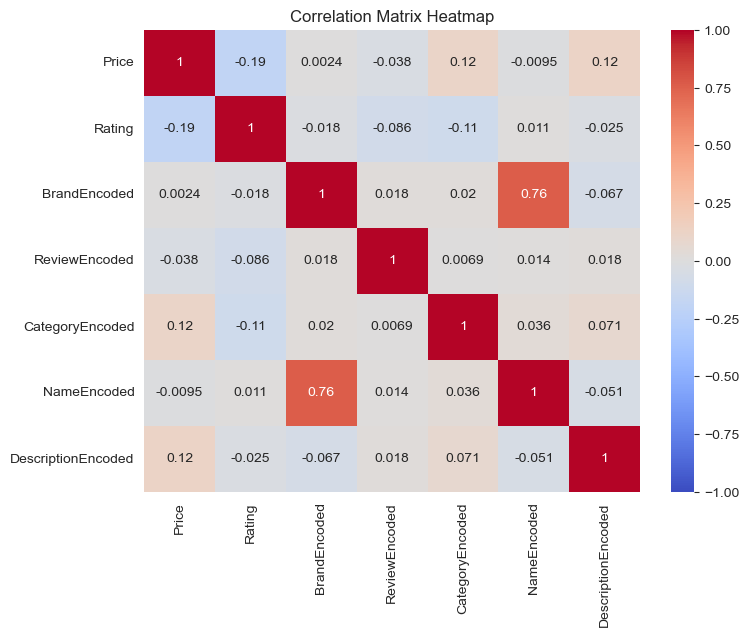

In [323]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [324]:
# combine both Review and Description

df['ReviewAndDescription'] = df['CleanedReview'] + ' ' + df['CleanedDescription']

In [325]:
def generate_ngrams(tokens, n):
    ngrams_list = list(ngrams(tokens, n))
    return [" ".join(gram) for gram in ngrams_list]


def generate_grams(col_df, size):
    ngrams_all = []
    for document in col_df:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        ngrams_all.extend(generate_ngrams(tokens, size))

    cnt_ngram = Counter(ngrams_all)
    most_common_ngrams = cnt_ngram.most_common(15)

    temp_df = pd.DataFrame(most_common_ngrams, columns=['words', 'count'])
    temp_df = temp_df.sort_values(by='count', ascending=False)

    return temp_df


def plot_n_grams(col_df):
    unigrams = generate_grams(col_df, 1)
    bigrams = generate_grams(col_df, 2)
    trigrams = generate_grams(col_df, 3)

    # Set plot figure size
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))  # 3 rows, 1 column

    # Plot Unigrams
    ax1.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=.5)
    ax1.set_title('Unigrams')
    ax1.set_yticks(np.arange(len(unigrams['words'])))
    ax1.set_yticklabels(unigrams['words'])
    ax1.set_xlabel('Count')

    # Plot Bigrams
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=.5)
    ax2.set_title('Bigrams')
    ax2.set_yticks(np.arange(len(bigrams['words'])))
    ax2.set_yticklabels(bigrams['words'])
    ax2.set_xlabel('Count')

    # Plot Trigrams
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax3.set_title('Trigrams')
    ax3.set_yticks(np.arange(len(trigrams['words'])))
    ax3.set_yticklabels(trigrams['words'])
    ax3.set_xlabel('Count')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()



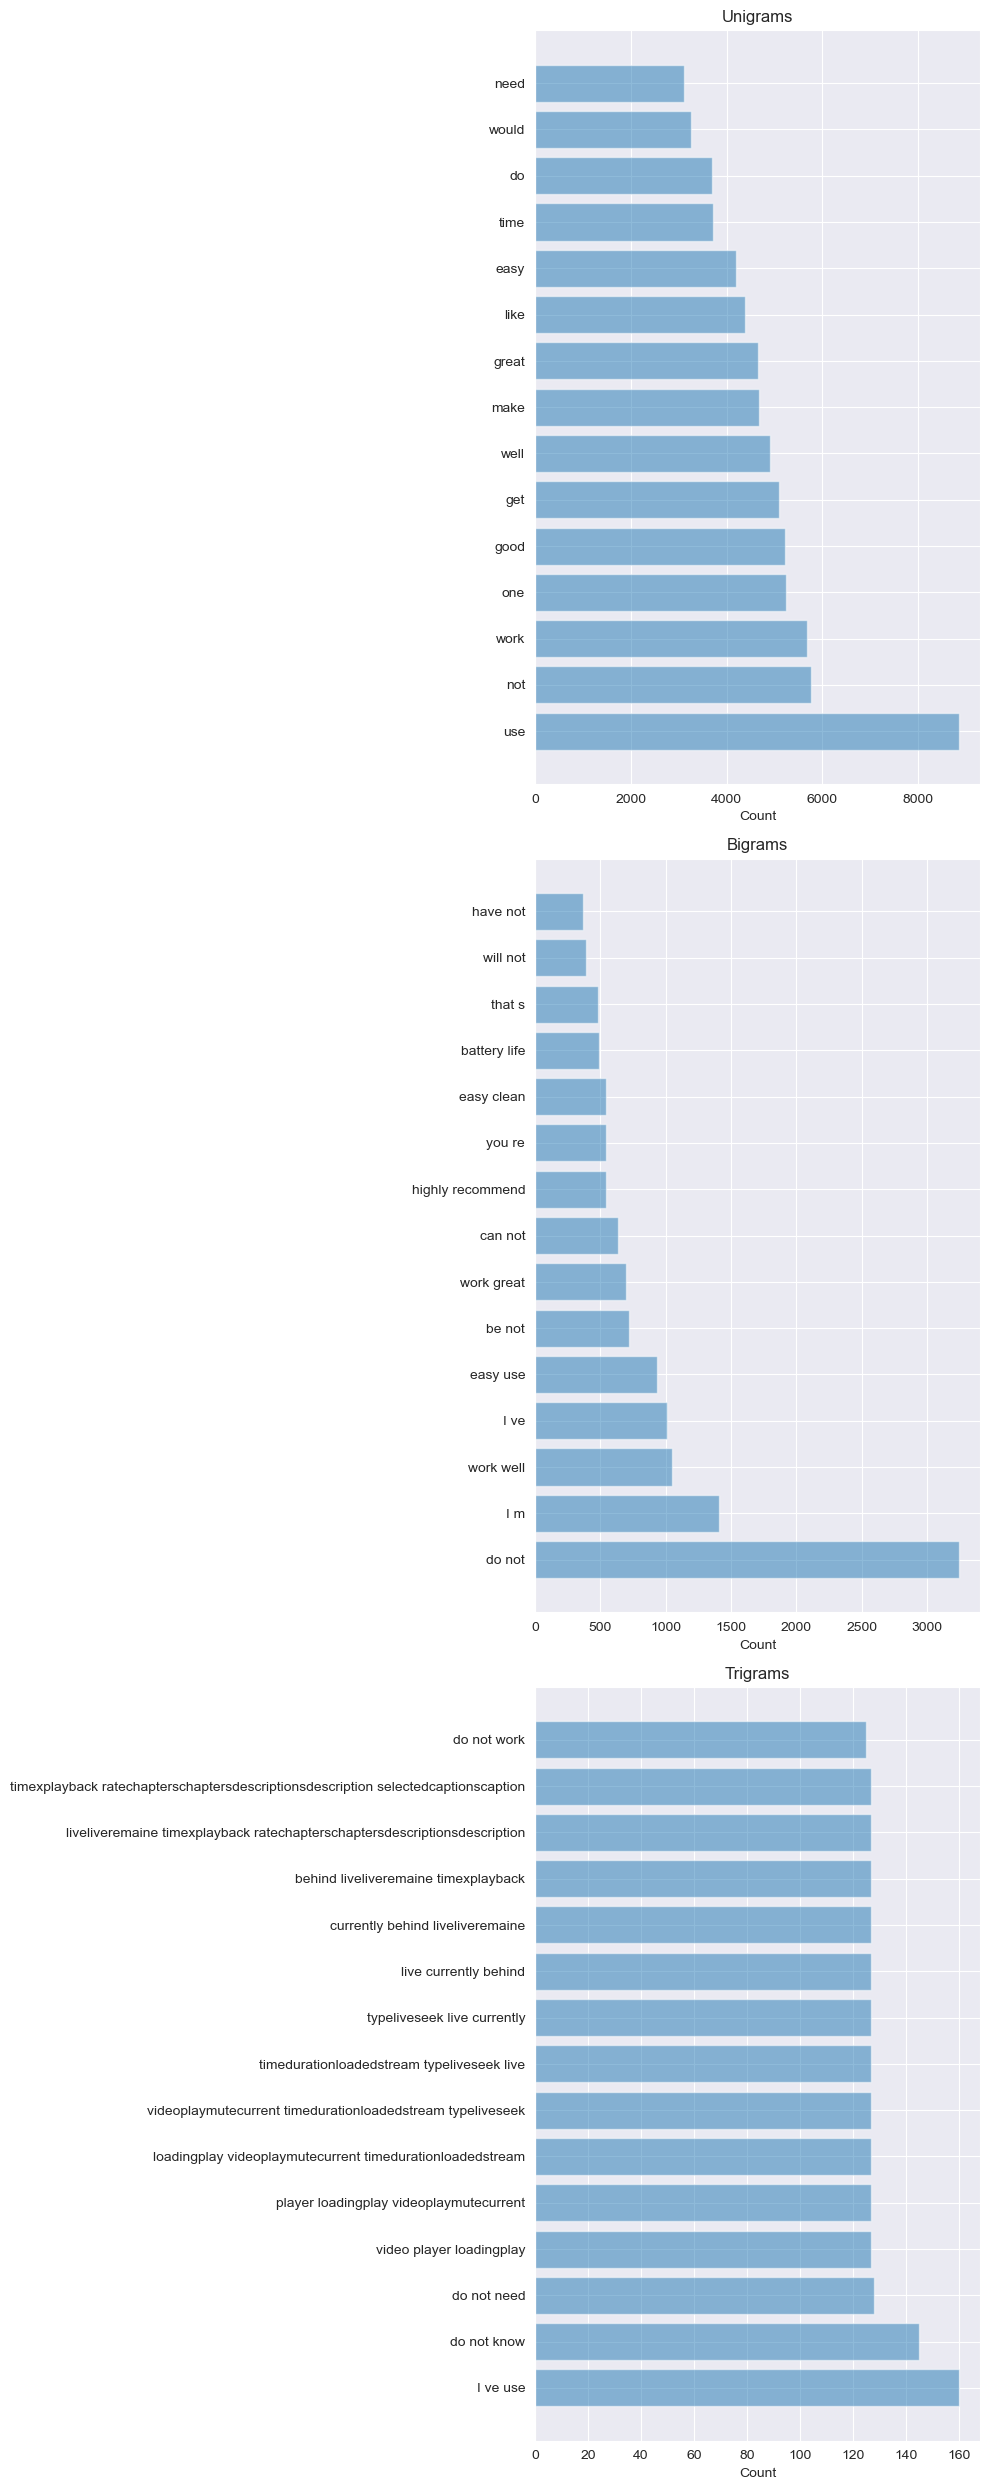

In [326]:
plot_n_grams(df['ReviewAndDescription'])

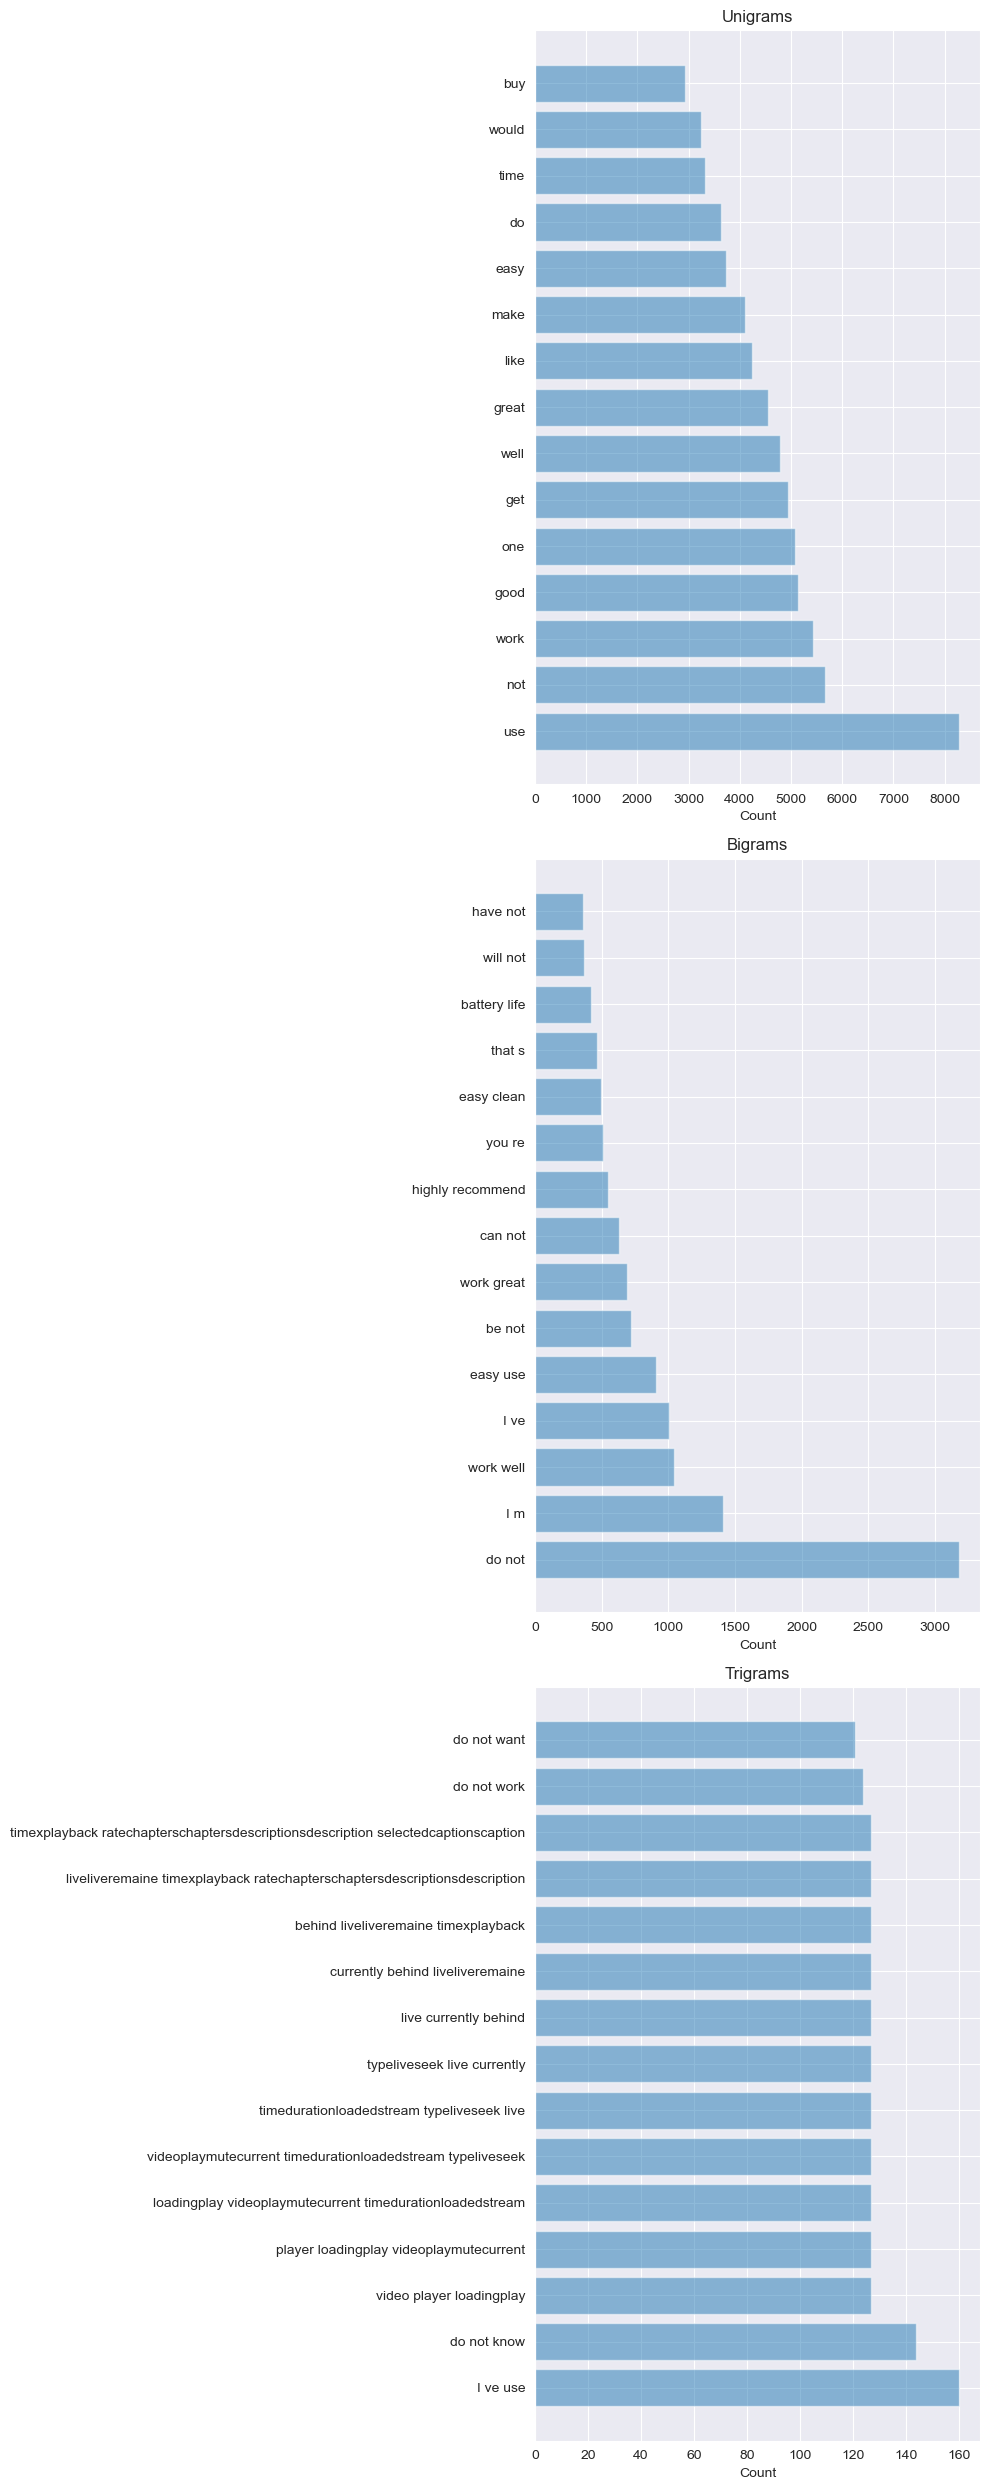

In [327]:
plot_n_grams(df['CleanedReview'])

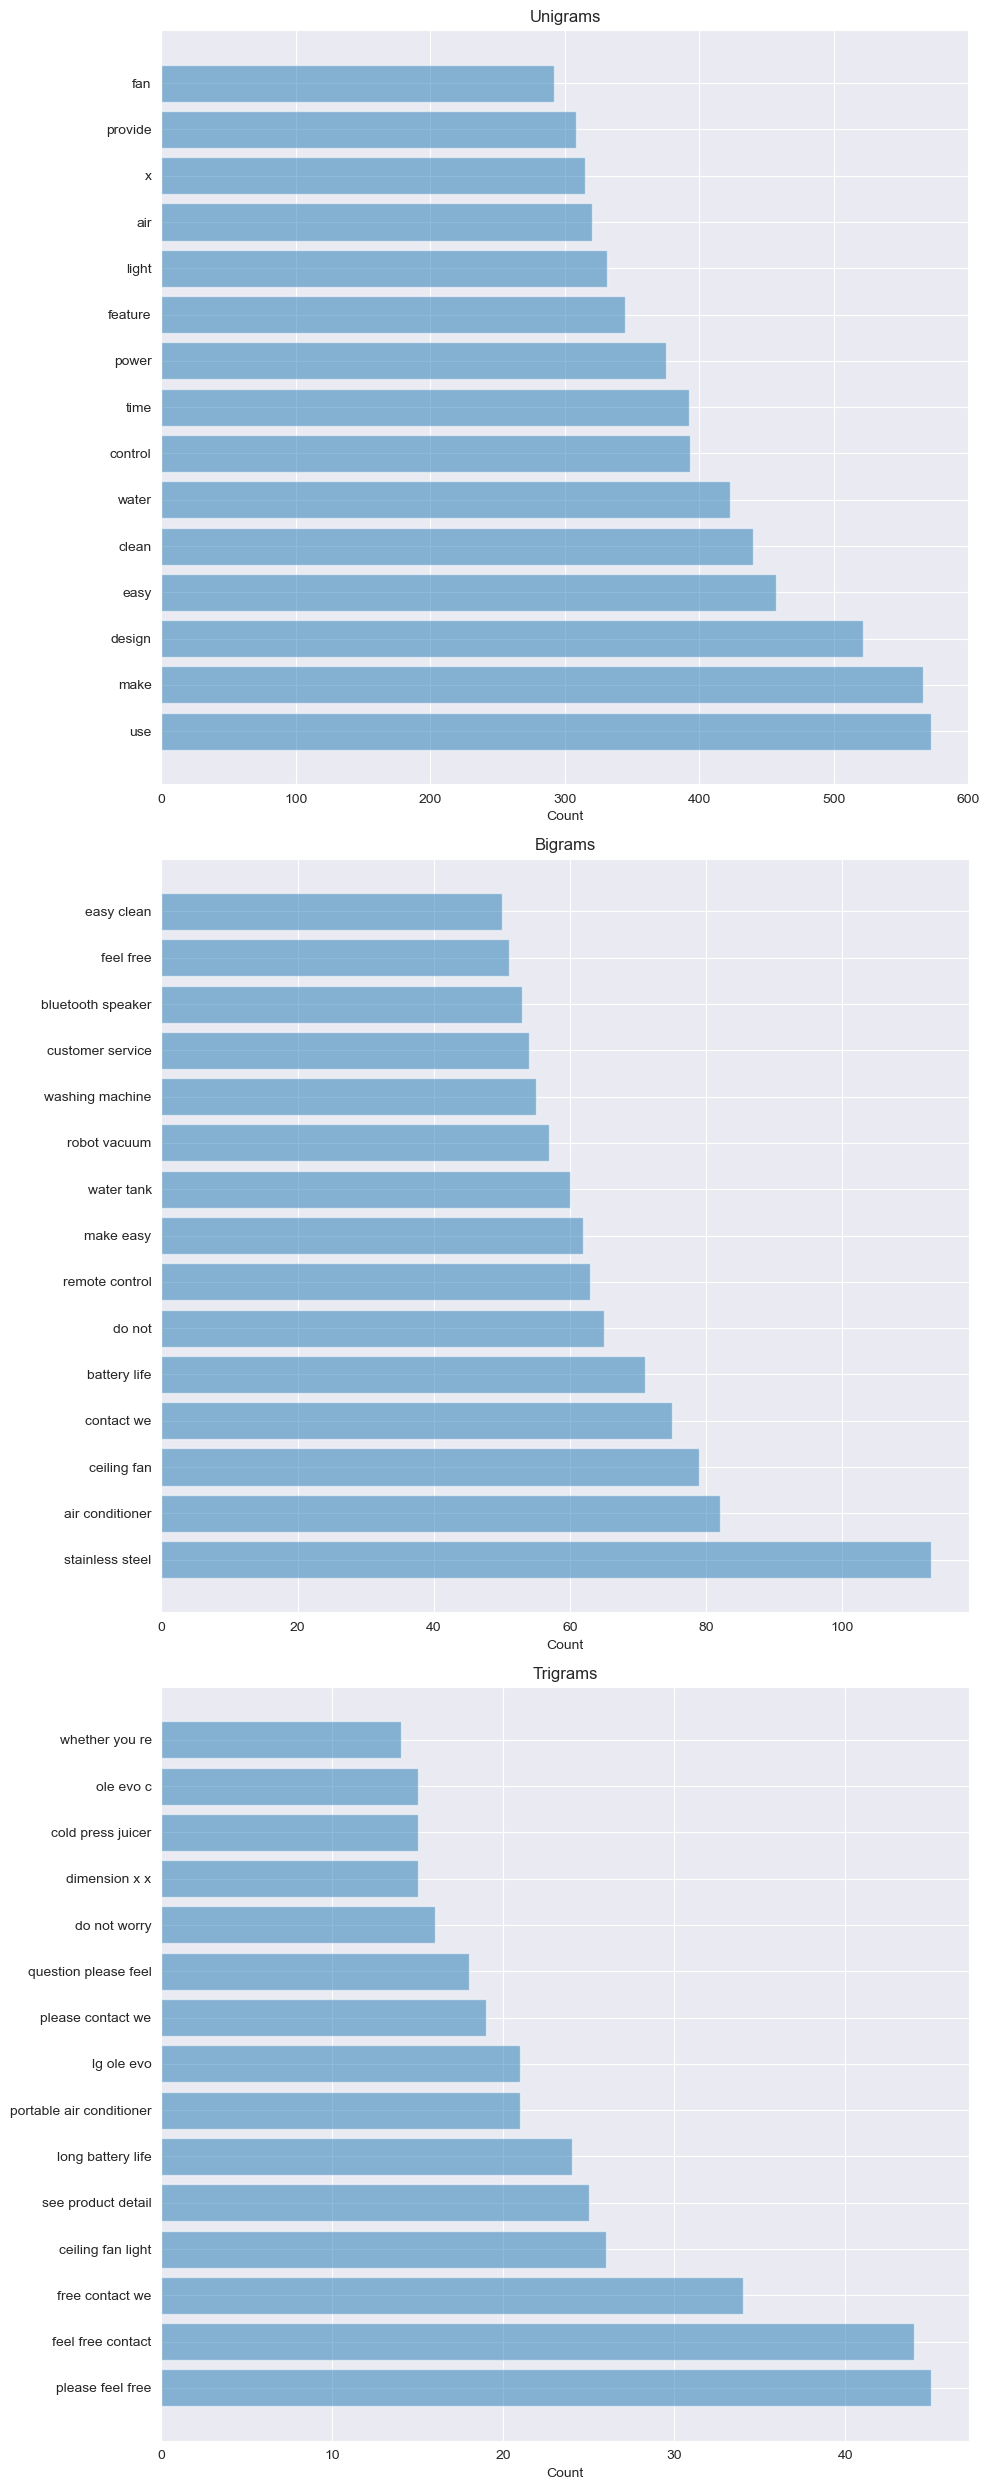

In [328]:
plot_n_grams(df['CleanedDescription'])

World Cloud

In [329]:
def generate_word_cloud(category: str):
    text_wrangler.plot_word_cloud(' '.join(df[category]), f'{category} Word Cloud using TF-IDF')

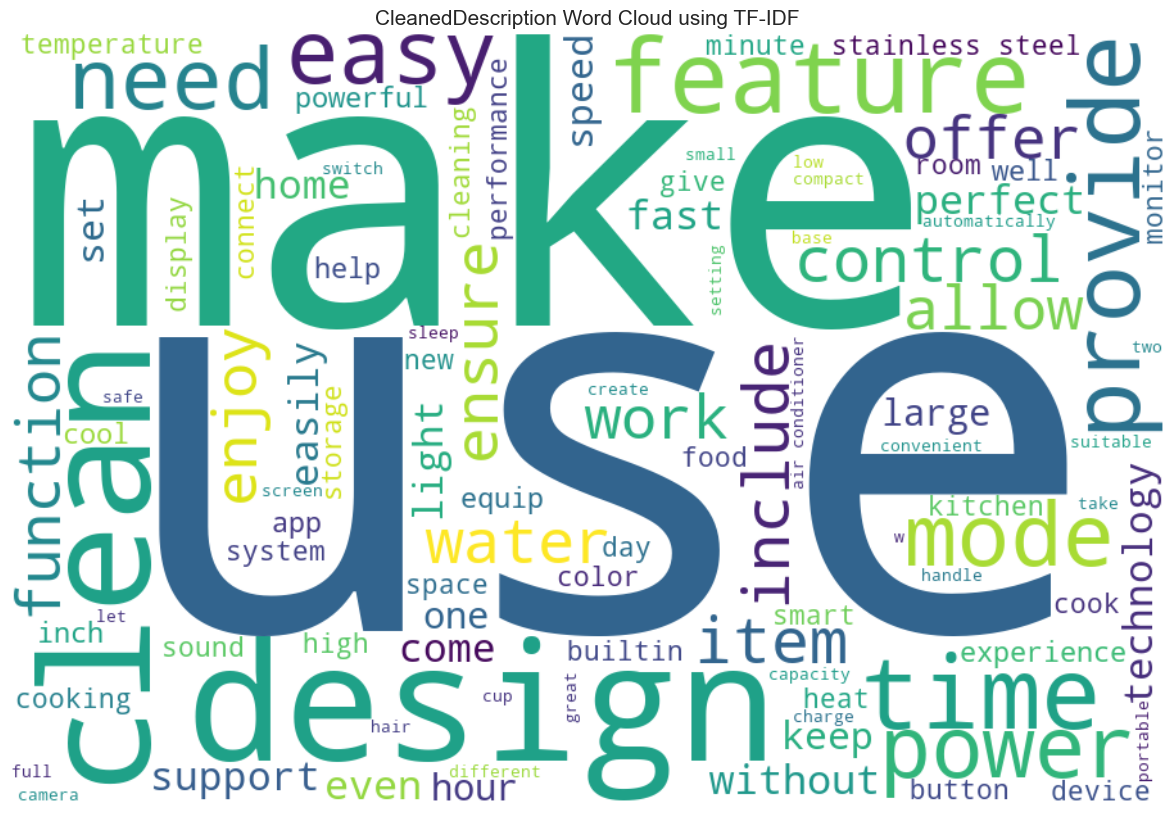

In [330]:
generate_word_cloud(category='CleanedDescription')

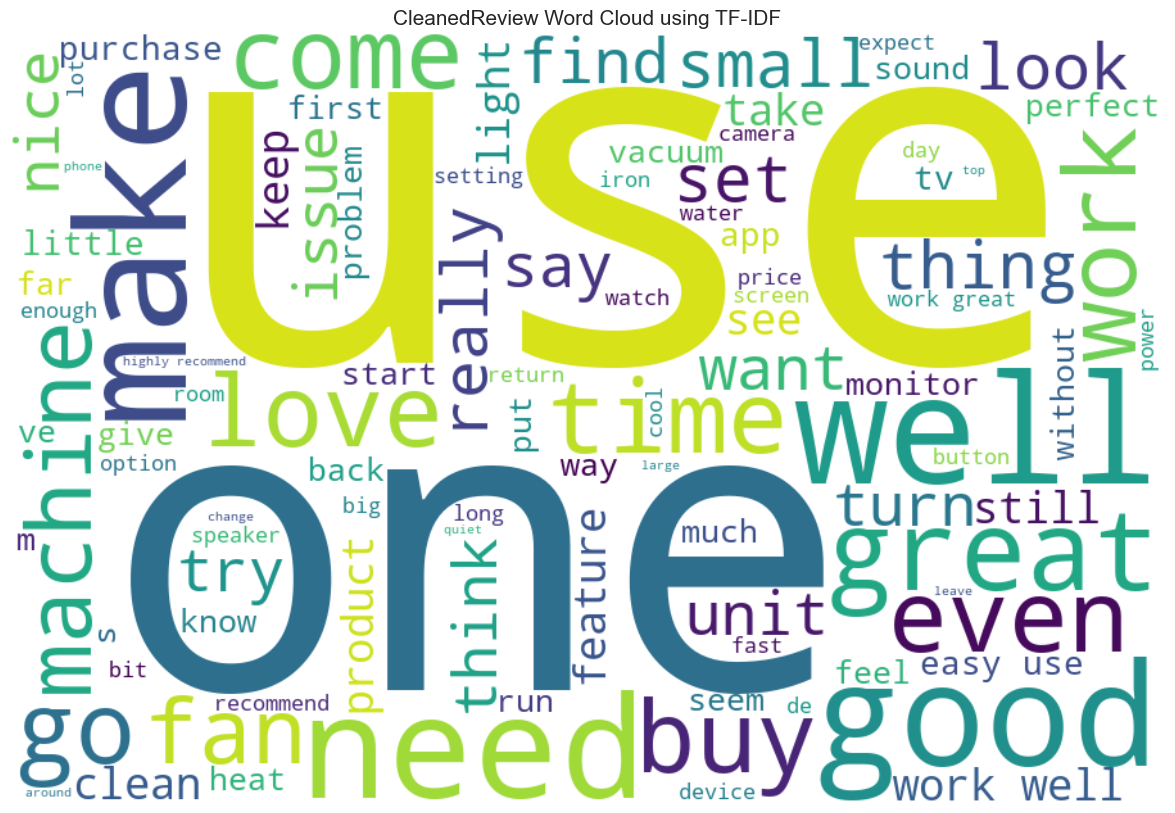

In [331]:
generate_word_cloud(category='CleanedReview')

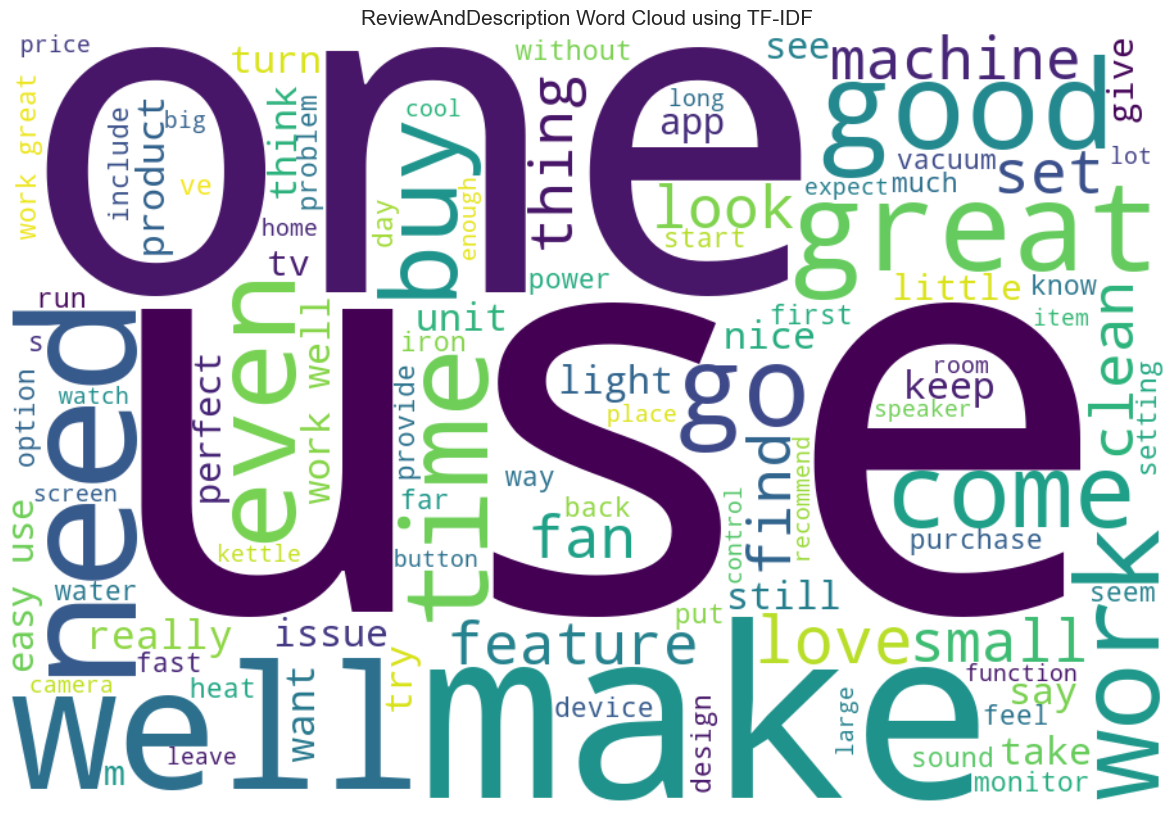

In [332]:
generate_word_cloud(category='ReviewAndDescription')

Word Vectorization using TF-IDF and Bag of Words

In [333]:
class Vectorization:
    def __init__(self, vectorizer='tfidf', ngram_end_range=1):
        if vectorizer == 'tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=(1, ngram_end_range), max_features=1000)
        elif vectorizer == 'bow':
            self.vectorizer = CountVectorizer(ngram_range=(1, ngram_end_range), max_features=1000)
        else:
            raise ValueError("Invalid vectorizer. Choose 'tfidf' or 'bow'.")

    @staticmethod
    def plot_word_cloud(data, title):
        wordcloud = WordCloud(width=900, height=600, max_words=100, background_color='white').generate_from_frequencies(
            data)

        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return


In [334]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['ReviewAndDescription'])

# Bag of Words Vectorization
bow_vectorizer = CountVectorizer(max_features=1000)
X_bow = bow_vectorizer.fit_transform(df['ReviewAndDescription'])


Sentiment Analysis

In [335]:
class TextSentimentAnalysis:
    def __init__(self):
        self.sid = SentimentIntensityAnalyzer()

    def get_sentiment_via_vader(self, text: str) -> float:
        # Using compound score as a single sentiment score
        return self.sid.polarity_scores(text)['compound']


In [336]:
text_sentiment_analysis = TextSentimentAnalysis()

In [337]:
# Getting the overall sentiment of the Review and Description
df['ReviewSentiment'] = df['Review'].apply([text_sentiment_analysis.get_sentiment_via_vader])
df['DescriptionSentiment'] = df['Description'].apply(text_sentiment_analysis.get_sentiment_via_vader)
df['ReviewAndDescriptionSentiment'] = df['ReviewAndDescription'].apply(text_sentiment_analysis.get_sentiment_via_vader)

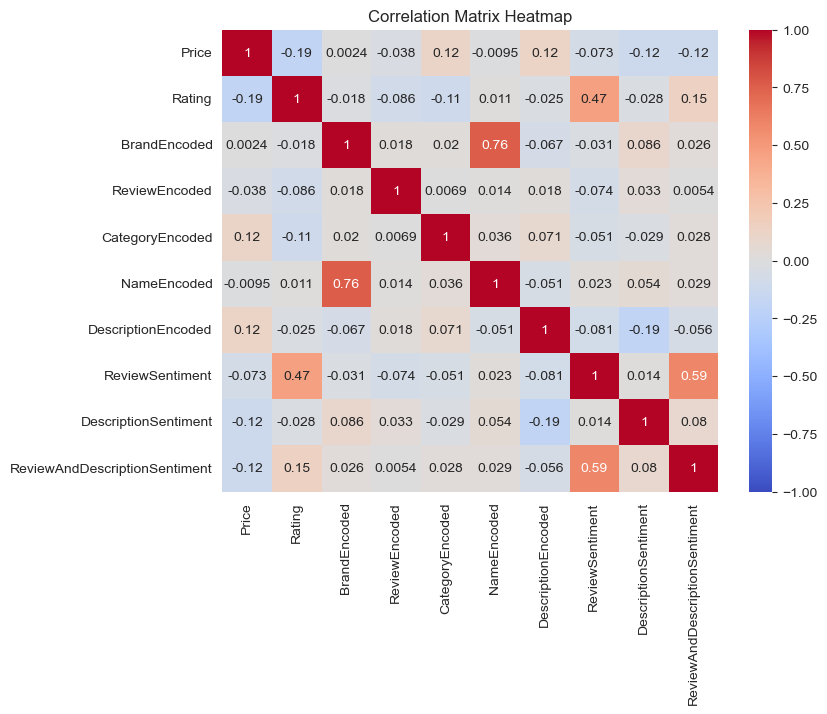

In [338]:
# drawing correlation matrix head map after applying sentiment analysis

corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Classification Model

In [339]:
class ClassificationModel:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = None  # To store the trained model

    def train_logistic_regression(self):
        model = LogisticRegression(max_iter=1000)
        model.fit(self.X_train, self.y_train)
        self.model = model
        return model

    def train_random_forest(self):
        model = RandomForestClassifier(n_estimators=10, random_state=42)
        model.fit(self.X_train, self.y_train)
        self.model = model
        return model

    def evaluate_model(self, model, model_name):
        y_pred_test = model.predict(self.X_test)
        y_pred_train = model.predict(self.X_train)

        # Compute accuracy
        accuracy_test = accuracy_score(self.y_test, y_pred_test)
        accuracy_train = accuracy_score(self.y_train, y_pred_train)

        # Compute confusion matrix
        cm_test = confusion_matrix(self.y_test, y_pred_test)
        cm_train = confusion_matrix(self.y_train, y_pred_train)

        # Print classification report
        print(f"{model_name} - Test Data:\n", classification_report(self.y_test, y_pred_test, zero_division=1))
        print(f"{model_name} - Train Data:\n", classification_report(self.y_train, y_pred_train, zero_division=1))

        return accuracy_train, accuracy_test, cm_train, cm_test


# Split the data for both TF-IDF and Bag of words
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, df['PriceRange'], test_size=0.2,
                                                                            random_state=42)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, df['PriceRange'], test_size=0.2,
                                                                    random_state=42)

# Create instances of ClassificationModel for TF-IDF and Bag of Words
tfidf_classifier = ClassificationModel(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)
bow_classifier = ClassificationModel(X_train_bow, X_test_bow, y_train_bow, y_test_bow)

# Train models
log_reg_tfidf_model = tfidf_classifier.train_logistic_regression()
rf_tfidf_model = tfidf_classifier.train_random_forest()
log_reg_bow_model = bow_classifier.train_logistic_regression()
rf_bow_model = bow_classifier.train_random_forest()

# Evaluate models and get metrics
acc_train_lr_tfidf, acc_test_lr_tfidf, cm_train_lr_tfidf, cm_test_lr_tfidf = tfidf_classifier.evaluate_model(
    log_reg_tfidf_model, "TF-IDF Logistic Regression")
acc_train_rf_tfidf, acc_test_rf_tfidf, cm_train_rf_tfidf, cm_test_rf_tfidf = tfidf_classifier.evaluate_model(
    rf_tfidf_model, "TF-IDF Random Forest")
acc_train_lr_bow, acc_test_lr_bow, cm_train_lr_bow, cm_test_lr_bow = bow_classifier.evaluate_model(log_reg_bow_model,
                                                                                                   "Bag of Words Logistic Regression")
acc_train_rf_bow, acc_test_rf_bow, cm_train_rf_bow, cm_test_rf_bow = bow_classifier.evaluate_model(rf_bow_model,
                                                                                                   "Bag of Words Random Forest")

# Print or use the accuracy and confusion matrices as needed
print("TF-IDF with Logistic Regression - Train Accuracy:", acc_train_lr_tfidf)
print("TF-IDF with Logistic Regression - Test Accuracy:", acc_test_lr_tfidf)
print("TF-IDF with Logistic Regression - Train Confusion Matrix:")
print(cm_train_lr_tfidf)
print("TF-IDF with Logistic Regression - Test Confusion Matrix:")
print(cm_test_lr_tfidf)

print('\n')

print("TF-IDF with Random Forest - Train Accuracy:", acc_train_rf_tfidf)
print("TF-IDF with Random Forest - Test Accuracy:", acc_test_rf_tfidf)
print("TF-IDF with Random Forest - Train Confusion Matrix:")
print(cm_train_rf_tfidf)
print("TF-IDF with Random Forest - Test Confusion Matrix:")
print(cm_test_rf_tfidf)

print('\n')

print("Bag of Words with Logistic Regression - Train Accuracy:", acc_train_lr_bow)
print("Bag of Words with Logistic Regression - Test Accuracy:", acc_test_lr_bow)
print("Bag of Words with Logistic Regression - Train Confusion Matrix:")
print(cm_train_lr_bow)
print("Bag of Words with Logistic Regression - Test Confusion Matrix:")
print(cm_test_lr_bow)

print('\n')

print("Bag of Words with Random Forest - Train Accuracy:", acc_train_rf_bow)
print("Bag of Words with Random Forest - Test Accuracy:", acc_test_rf_bow)
print("Bag of Words with Random Forest - Train Confusion Matrix:")
print(cm_train_rf_bow)
print("Bag of Words with Random Forest - Test Confusion Matrix:")
print(cm_test_rf_bow)

TF-IDF Logistic Regression - Test Data:
               precision    recall  f1-score   support

   low-range       0.79      0.93      0.85        71
   mid-range       0.80      0.75      0.77        68
     premium       1.00      0.00      0.00         9

    accuracy                           0.79       148
   macro avg       0.86      0.56      0.54       148
weighted avg       0.80      0.79      0.76       148

TF-IDF Logistic Regression - Train Data:
               precision    recall  f1-score   support

   low-range       0.83      0.96      0.89       319
   mid-range       0.81      0.75      0.78       240
     premium       1.00      0.00      0.00        30

    accuracy                           0.82       589
   macro avg       0.88      0.57      0.55       589
weighted avg       0.83      0.82      0.80       589

TF-IDF Random Forest - Test Data:
               precision    recall  f1-score   support

   low-range       0.59      0.77      0.67        71
   mid-rang

In [340]:
# Define parameter grid for Logistic Regression
param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Grid search for Logistic Regression with TF-IDF
grid_search_logistic_tfidf = GridSearchCV(LogisticRegression(max_iter=10000), param_grid_logistic, cv=5,
                                          scoring='accuracy', n_jobs=-1)
grid_search_logistic_tfidf.fit(X_train_tfidf, y_train_tfidf)
best_params_logistic_tfidf = grid_search_logistic_tfidf.best_params_
best_model_logistic_tfidf = grid_search_logistic_tfidf.best_estimator_
print(f"Best Parameters for Logistic Regression with TF-IDF: {best_params_logistic_tfidf}")

# Grid search for Logistic Regression with Bag of Words
grid_search_logistic_bow = GridSearchCV(LogisticRegression(max_iter=10000), param_grid_logistic, cv=5,
                                        scoring='accuracy', n_jobs=-1)
grid_search_logistic_bow.fit(X_train_bow, y_train_bow)
best_params_logistic_bow = grid_search_logistic_bow.best_params_
best_model_logistic_bow = grid_search_logistic_bow.best_estimator_
print(f"Best Parameters for Logistic Regression with Bag of Words: {best_params_logistic_bow}")

# Evaluate best models
y_pred_best_logistic_tfidf = best_model_logistic_tfidf.predict(X_test_tfidf)
y_pred_best_logistic_bow = best_model_logistic_bow.predict(X_test_bow)
print("Best TF-IDF Logistic Regression:\n",
      classification_report(y_test_tfidf, y_pred_best_logistic_tfidf, zero_division=1))
print("Best Bag of Words Logistic Regression:\n",
      classification_report(y_test_bow, y_pred_best_logistic_bow, zero_division=1))

Best Parameters for Logistic Regression with TF-IDF: {'C': 1, 'solver': 'saga'}
Best Parameters for Logistic Regression with Bag of Words: {'C': 0.01, 'solver': 'liblinear'}
Best TF-IDF Logistic Regression:
               precision    recall  f1-score   support

   low-range       0.79      0.93      0.85        71
   mid-range       0.80      0.75      0.77        68
     premium       1.00      0.00      0.00         9

    accuracy                           0.79       148
   macro avg       0.86      0.56      0.54       148
weighted avg       0.80      0.79      0.76       148

Best Bag of Words Logistic Regression:
               precision    recall  f1-score   support

   low-range       0.75      0.89      0.81        71
   mid-range       0.77      0.71      0.74        68
     premium       0.50      0.11      0.18         9

    accuracy                           0.76       148
   macro avg       0.67      0.57      0.58       148
weighted avg       0.75      0.76      0.74  

In [344]:
# implementing the recommendation from above

# Define the best parameters obtained from GridSearchCV
best_params_lr_tfidf = {'C': 1, 'solver': 'saga'}
best_params_lr_bow = {'C': 0.01, 'solver': 'liblinear'}

# Initialize Logistic Regression models with best parameters
best_model_lr_tfidf = LogisticRegression(C=best_params_lr_tfidf['C'], solver=best_params_lr_tfidf['solver'],
                                         max_iter=10000)
best_model_lr_bow = LogisticRegression(C=best_params_lr_bow['C'], solver=best_params_lr_bow['solver'], max_iter=10000)

# Fit the models on the training data
best_model_lr_tfidf.fit(X_train_tfidf, y_train_tfidf)
best_model_lr_bow.fit(X_train_bow, y_train_bow)

# Predict on train and test data
y_pred_train_lr_tfidf = best_model_lr_tfidf.predict(X_train_tfidf)
y_pred_test_lr_tfidf = best_model_lr_tfidf.predict(X_test_tfidf)

y_pred_train_lr_bow = best_model_lr_bow.predict(X_train_bow)
y_pred_test_lr_bow = best_model_lr_bow.predict(X_test_bow)

# Calculate accuracy scores
accuracy_train_lr_tfidf = accuracy_score(y_train_tfidf, y_pred_train_lr_tfidf)
accuracy_test_lr_tfidf = accuracy_score(y_test_tfidf, y_pred_test_lr_tfidf)

accuracy_train_lr_bow = accuracy_score(y_train_bow, y_pred_train_lr_bow)
accuracy_test_lr_bow = accuracy_score(y_test_bow, y_pred_test_lr_bow)

# Calculate confusion matrices
cm_train_lr_tfidf = confusion_matrix(y_train_tfidf, y_pred_train_lr_tfidf)
cm_test_lr_tfidf = confusion_matrix(y_test_tfidf, y_pred_test_lr_tfidf)

cm_train_lr_bow = confusion_matrix(y_train_bow, y_pred_train_lr_bow)
cm_test_lr_bow = confusion_matrix(y_test_bow, y_pred_test_lr_bow)

# Print results
print("TF-IDF Logistic Regression - Train Accuracy:", accuracy_train_lr_tfidf)
print("TF-IDF Logistic Regression - Test Accuracy:", accuracy_test_lr_tfidf)
print("TF-IDF Logistic Regression - Train Confusion Matrix:")
print(cm_train_lr_tfidf)
print("\n")

print("TF-IDF Logistic Regression - Test Confusion Matrix:")
print(cm_test_lr_tfidf)

print("\n")

print("Bag of Words Logistic Regression - Train Accuracy:", accuracy_train_lr_bow)
print("Bag of Words Logistic Regression - Test Accuracy:", accuracy_test_lr_bow)
print("Bag of Words Logistic Regression - Train Confusion Matrix:")
print(cm_train_lr_bow)
print("\n")

print("Bag of Words Logistic Regression - Test Confusion Matrix:")
print(cm_test_lr_bow)


TF-IDF Logistic Regression - Train Accuracy: 0.8217317487266553
TF-IDF Logistic Regression - Test Accuracy: 0.7905405405405406
TF-IDF Logistic Regression - Train Confusion Matrix:
[[305  14   0]
 [ 61 179   0]
 [  2  28   0]]


TF-IDF Logistic Regression - Test Confusion Matrix:
[[66  5  0]
 [17 51  0]
 [ 1  8  0]]


Bag of Words Logistic Regression - Train Accuracy: 0.9728353140916808
Bag of Words Logistic Regression - Test Accuracy: 0.7567567567567568
Bag of Words Logistic Regression - Train Confusion Matrix:
[[317   2   0]
 [  9 230   1]
 [  0   4  26]]


Bag of Words Logistic Regression - Test Confusion Matrix:
[[63  8  0]
 [19 48  1]
 [ 2  6  1]]
